# Deep Learning Project 2 - Group 6
Catarina Oliveira | 20211616;
Inês Vieira | 20211589;
Rita Centeno | 20211579


## **Building the Model**

#### Table of Contents:
1. [Library Imports](#import-libraries)
2. [Open Data](#opening-data)
3. [EDA](#eda)
4. [Preprocessing](#initial-preprocessing)
5. [Train Test Split](#train-test-split)
6. [Oversampling](#oversampling)
7. [Modeling](#modeling)
8. [Model Evaluation](#model-evaluation)
9. [Exports](#exports)

### Importing Necessary Libraries
<a id='import-libraries'></a>

In [60]:
# Imports

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow
# !pip install pillow
# !pip install opencv-python
# !pip install scikit-learn
# !pip install keras
# !pip install imbalanced-learn


# Importing standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf

# Importing image libraries
from PIL import Image #, ImageEnhance
# import cv2

# Importing scikit-learn libraries
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Importing Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import ReduceLROnPlateau
# from keras import regularizers

# Importing imblearn libraries
# from imblearn.over_sampling import RandomOverSampler

# Import pretrained models
# from tensorflow.keras.applications import (ResNet50, InceptionV3, DenseNet121, VGG16, Xception)

# Importing model evaluation libraries
# from tensorflow.keras.models import load_model

# Import garbage collector to free up memory
import gc

# Import warnings to silence warnings
import warnings
warnings.filterwarnings('ignore')

# Importing custom functions
from path import path
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Opening Data
<a id='opening-data'></a>

#### Metadata

In [42]:
metadata = pd.read_csv(path + "DataDL\\metadata.csv")

In [43]:
metadata.head()

,Image ID,Label
0,OAS1_0308_MR1_mpr-1_125.jpg,NaN
1,OAS1_0351_MR1_mpr-3_112.jpg,NaN
2,OAS1_0308_MR1_mpr-1_131.jpg,Moderate Dementia
3,OAS1_0351_MR1_mpr-3_106.jpg,Moderate Dementia
4,OAS1_0308_MR1_mpr-1_119.jpg,Moderate Dementia


In [44]:
# Check for duplicated rows
metadata['Image ID'].duplicated().sum()

0

In [45]:
# Check for missing values
metadata.isnull().sum()

Image ID    0
Label       9
dtype: int64

In [46]:
# Drop the 9 rows with missing values
metadata.dropna(inplace=True)

#### Images

In [47]:
# Paths
train_dir = path + "DataDL\\train\\"
test_dir = path + "DataDL\\test\\"

In [51]:
# Create empty lists to store labels and the arrays of images
labels_train = []
images_data_train = []
labels_test = []
images_data_test = []

# Load images and labels
for index, row in metadata.iterrows():
    image_name = row['Image ID']
    label = row['Label']

    # Check if the image belongs to the training set
    if os.path.exists(os.path.join(train_dir, image_name)):

        # Load image
        image_path = os.path.join(train_dir, image_name) 
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assign image to train set
        metadata.at[index, 'train'] = 1 
           
        # Append image and respective label to list
        labels_train.append(label) 
        images_data_train.append(img)

    elif os.path.exists(os.path.join(test_dir, image_name)):

        # Load image
        image_path = os.path.join(test_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assign image to test set
        metadata.at[index, 'train'] = 0

        # Append image and respective label to list
        labels_test.append(label)
        images_data_test.append(img)

    # Error message if image is not found
    else:
        print(f"Image not found: {image_name}")

In [56]:
del train_dir, test_dir, image_name, label, image_path, img, index, row
gc.collect()

2166

### EDA
<a id='eda'></a>

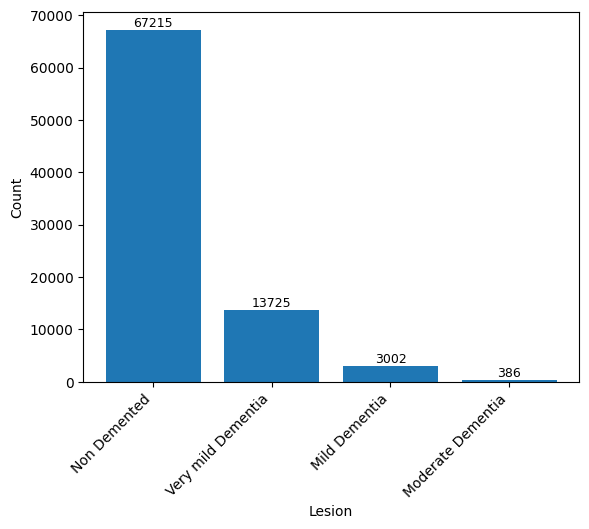

In [65]:
# Check the target variable's distribution
bar_chart(metadata, 'Label', 'Lesion', fontsize=9, rotation=45)

### Initial Preprocessing
<a id='initial-preproc'></a>

In [66]:
# Create a column with the original index for later checks
metadata['original_index'] = metadata.index

# Divide the metadata into the train and test sets and reset respective indices
train_metadata = metadata[metadata['train'] == 1].drop(['train'], axis=1)
test_metadata = metadata[metadata['train'] == 0].drop(['train'], axis=1)

train_metadata = train_metadata.reset_index(drop=True)
test_metadata = test_metadata.reset_index(drop=True)

# Create a column with the original train set index for later checks
train_metadata['original_train_index'] = train_metadata.index
test_metadata['original_test_index'] = test_metadata.index

In [67]:
del metadata
gc.collect()

13756

In [ ]:
# PREPROC BY BINGAI

import numpy as np
import cv2
from skimage import exposure

# assuming 'images' is your list of numpy arrays
preprocessed_images = []

for img in images:
    # Inhomogeneity correction: adjust the histogram of the image
    img_corrected = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    # Rigid registration: for this, you need a reference image to which others will be registered
    # Here, we'll use the first image in the list as the reference
    reference_image = images[0]
    
    # Find the transformation that aligns the image with the reference
    matrix, _ = cv2.estimateAffine2D(img_corrected, reference_image)
    
    # Apply the transformation
    registered_image = cv2.warpAffine(img_corrected, matrix, (img.shape[1], img.shape[0]))
    
    preprocessed_images.append(registered_image)


In [ ]:
# Extract hair, resize, normalize train and test images
preproc_images_data_train = inicial_preproc(images_data_train)
preproc_images_data_test = inicial_preproc(images_data_test)